In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests

%matplotlib inline

# Define functions:

In [5]:
u_a = "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/67.0.3396.87 Safari/537.36"

def shotchartdetail(leagueid='00',season='2017-18',seasontype='Regular Season',teamid=0,
                    playerid=0,gameid='',outcome='',location='',month=0,
                    seasonseg='',datefrom='',dateto='',oppteamid=0,vsconf='',
                    vsdiv='',pos='',gameseg='',per=0,lastngames=0,aheadbehind='',
                    contextmeasure='FGM',clutchtime='',rookieyear=''):
    '''
    Access to NBA API - http://stats.nba.com/stats/shotchartdetail
    Returns the shotchart requested and the leagueaverage
    Example:
    shot_data,leagueaverage = shotchartdetail(season='2016-17')
    '''
    url = 'http://stats.nba.com/stats/shotchartdetail?'
    api_param = {
         'LeagueID': leagueid,
         'Season' :  season,
         'SeasonType' : seasontype,
         'TeamID' : teamid,
         'PlayerID' : playerid,
         'GameID' : gameid,
         'Outcome' : outcome,
         'Location' : location,
         'Month' : month,
         'SeasonSegment' : seasonseg,
         'DateFrom' :  datefrom,
         'DateTo' : dateto,
         'OpponentTeamID' : oppteamid,
         'VsConference' : vsconf,
         'VsDivision' : vsdiv,
         'PlayerPosition' : pos,
         'GameSegment' : gameseg,
         'Period' :  per,
         'LastNGames' : lastngames,
         'AheadBehind' : aheadbehind,
         'ContextMeasure' : contextmeasure,
         'ClutchTime' : clutchtime,
         'RookieYear' : rookieyear
         }

    response = requests.get(url,params=api_param,headers={"USER-AGENT":u_a})
    data = response.json()
    Shot_Chart_Detail = pd.DataFrame(data['resultSets'][0]['rowSet'],columns=data['resultSets'][0]['headers'])
    LeagueAverage = pd.DataFrame(data['resultSets'][1]['rowSet'],columns=data['resultSets'][1]['headers'])
    return Shot_Chart_Detail,LeagueAverage

def seasons_string(start,end):
    '''
    creates a list of NBA seasons from start-end
    '''
    years = np.arange(start,end+1)
    seasons = []
    for year in years:
        string1 = str(year)
        string2 = str(year+1)
        season = '{}-{}'.format(string1,string2[-2:])
        seasons.append(season)
    return seasons

# Get Data:

In [6]:
df = []
for season in seasons_string(2012,2017):
    df.append(shotchartdetail(season=season))
    print(season)
    
df = pd.concat([x[0] for x in df],ignore_index=True)

2012-13
2013-14
2014-15
2015-16
2016-17
2017-18


# Data Analysis:

In [7]:
def get_time_seconds(g):
    """ Use shotcart dataframe columns to get time in seconds """
    period = g['PERIOD']
    min_remaining = g['MINUTES_REMAINING']
    sec_remaining = g['SECONDS_REMAINING']
    return np.where(period < 5, period*12*60 - min_remaining*60-sec_remaining,4*12*60 + (period-4)*5*60 - min_remaining*60-sec_remaining)

In [8]:
df['TIME'] = get_time_seconds(df)
### Create time buckets to use for aggregation
df['TIME_BUCKET'],time_bins = pd.cut(df['TIME'],bins=np.arange(0,60*48+1,24),retbins=True)

In [9]:
### Apply aggregation
time_summary = df.groupby(['TIME_BUCKET','SHOT_ZONE_RANGE'])['SHOT_MADE_FLAG'].agg(['mean','size']).unstack(1)
time_summary[('size','all')] = time_summary.iloc[:,5:].sum(axis=1)
time_summary.head()

mean                                                      \
SHOT_ZONE_RANGE 16-24 ft.   24+ ft.  8-16 ft. Back Court Shot Less Than 8 ft.   
TIME_BUCKET                                                                     
(0, 24]          0.419728  0.378265  0.377063             0.0        0.530072   
(24, 48]         0.395435  0.367139  0.388824             0.0        0.538932   
(48, 72]         0.410394  0.381966  0.396248             NaN        0.539906   
(72, 96]         0.409153  0.378694  0.393850             NaN        0.563738   
(96, 120]        0.415215  0.396947  0.404538             0.0        0.571067   

                     size                                                   \
SHOT_ZONE_RANGE 16-24 ft. 24+ ft. 8-16 ft. Back Court Shot Less Than 8 ft.   
TIME_BUCKET                                                                  
(0, 24]            1470.0  1187.0   1212.0             1.0          2494.0   
(24, 48]           2147.0  2258.0   1700.0             3.0          3763.0   
(48, 72]           2232.0  2584.0   1759.0             NaN          4260.0   
(72, 96]           2185.0  2741.0   1691.0             NaN          4291.0   
(96, 120]          2182.0  2751.0   1807.0             1.0          4348.0   

                          
SHOT_ZONE_RANGE      all  
TIME_BUCKET               
(0, 24]           6364.0  
(24, 48]          9871.0  
(48, 72]         10835.0  
(72, 96]         10908.0  
(96, 120]        11089.0

# Plotting:

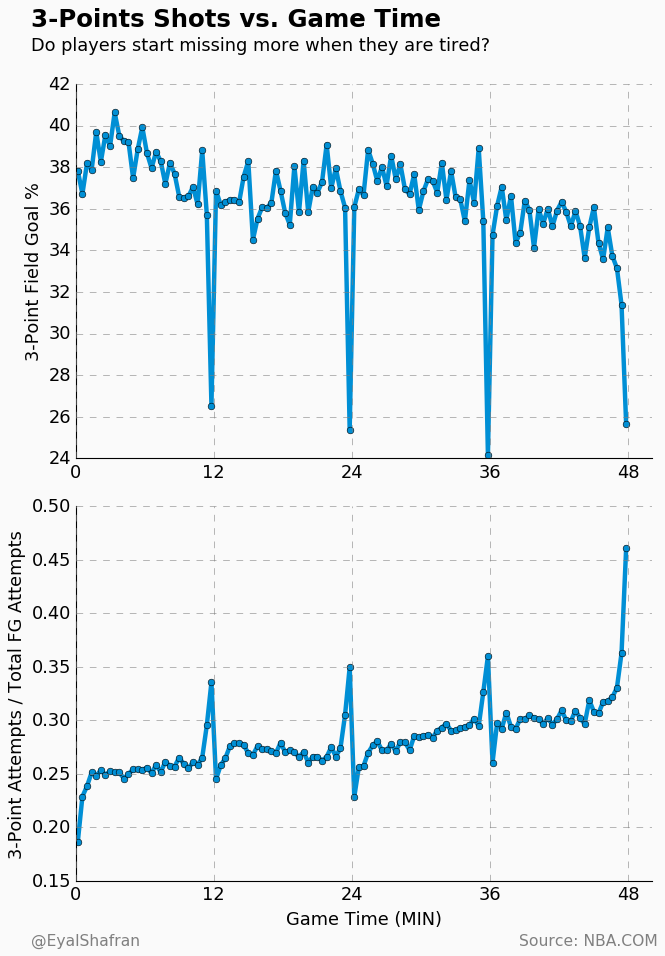

In [11]:
### This part takes care of the plot style
plt.style.use('classic')
    
fig = plt.figure(figsize=(8,12))

bg_color = (0.98,0.98,0.98)
fig.set_facecolor(bg_color)

# create labels and title for figure
fig.text(0.01,0.01,'@EyalShafran',fontsize=14.0,color='gray',
         horizontalalignment='left',verticalalignment='bottom')
fig.text(0.99,0.01,'Source: NBA.COM',fontsize=14.0,color='gray',
         horizontalalignment='right',verticalalignment='bottom')

fig.text(0.01,0.99,'3-Points Shots vs. Game Time',fontsize=22.0,
        horizontalalignment='left',weight="bold",verticalalignment='top')

fig.text(0.01,0.96,'Do players start missing more when they are tired?',transform=fig.transFigure,fontsize=16.0,
        horizontalalignment='left',verticalalignment='top')

fig.text(0.53,0.04,'Game Time (MIN)',fontsize=16.0,color='black',
               horizontalalignment='center',verticalalignment='center')

ax_left = 0.08
ax_bottom = 0.08
ax_width = 0.9
ax_height = 0.83

h_margin = 0.05

fig_width = ax_width
fig_height = (ax_height - h_margin)/2 

ws = np.tile(np.arange(ax_left,ax_width+ax_left,fig_width),(1,2)).flatten()
hs = np.tile(np.arange(ax_bottom,ax_height+ax_bottom,fig_height+h_margin)[::-1],(1,1)).T.flatten()

ax = []

for i in range(2):
    ax.append(fig.add_axes([ws[i], hs[i], fig_width, fig_height]))
    ax[i].set_facecolor(bg_color)   
    ax[i].grid('on', linestyle='--',color='gray')
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].axes.tick_params(length=0)
    ax[i].tick_params(labelsize=16)
    

### Here we do the actual plotting
colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c']

x = 0.5*(time_bins[1:]+time_bins[:-1])/60
y = 100*time_summary.loc[:,('mean','24+ ft.')]
ax[0].plot(x,y,'o-',color=colors[0],linewidth=4)
ax[0].set_xticks([0,12,24,36,48])
ax[0].set_ylabel('3-Point Field Goal %',fontsize=16)

x = 0.5*(time_bins[1:]+time_bins[:-1])/60
y = time_summary.loc[:,('size','24+ ft.')]/time_summary.loc[:,('size','all')]
ax[1].plot(x,y,'o-',color=colors[0],linewidth=4)
ax[1].set_xticks([0,12,24,36,48]);
ax[1].set_ylabel('3-Point Attempts / Total FG Attempts',fontsize=16)

fig.savefig('shooting_vs_time.png',bbox_inches='tight',facecolor=fig.get_facecolor(), edgecolor='none')